In [6]:
import time
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, count, avg, desc


def weak_test(num_nodes, data_fraction, hdfs_host="192.168.2.156", master_host="192.168.2.156"):
    conf = SparkConf().setAppName(f"Reddit-Webis-TLDR-17 Analysis - {num_nodes} Nodes") \
        .set("spark.executor.instances", str(num_nodes))
    spark = SparkSession.builder \
        .master(f"spark://{master_host}:7077") \
        .config(conf=conf) \
        .appName("Reddit-Webis-TLDR-17 Analysis")\
        .getOrCreate()
    
    print(f"Running test with {num_nodes} executors and {data_fraction*100}% of the data")
    
    data_path = "hdfs://192.168.2.235:9000/user/ubuntu/corpus-webis-tldr-17.json"
    
    df = spark.read.json(data_path)
    df_sampled = df.sample(fraction=data_fraction, seed=42)  
    
    start_time = time.time()
    df_sampled = df_sampled.dropna(subset=["content", "summary"])
    df_sampled = df_sampled.withColumn("content_length", length(col("content")))
    df_sampled = df_sampled.withColumn("summary_length", length(col("summary")))
    record_count = df_sampled.count()  
    desc_stats = df_sampled.select(
        avg("content_length").alias("avg_content_length"),
        avg("summary_length").alias("avg_summary_length")
    ).toPandas()
    end_time = time.time()
    
    execution_time = end_time - start_time
    print(f"Nodes: {num_nodes}, Data Size: {record_count} records, Execution Time: {execution_time:.2f} seconds")
    spark.stop()
    
    return execution_time, record_count

def run_scaling_tests(node_counts=[1, 2,3, 4,5,6,7, 8], base_fraction=0.1, runs_per_config=1):
    results = {}
    
    for i, nodes in enumerate(node_counts):
        fraction = base_fraction * nodes
        
        if fraction > 1:
            print(f"Warning: Fraction {fraction} exceeds 1, capping at 1.0")
            fraction = 1.0
            
        times = []
        for run in range(1, runs_per_config + 1):  
            print(f"\nStarting test with {nodes} nodes。and {fraction*100}% of the data - Run {run}/{runs_per_config}")
            time_taken, records = weak_test(nodes, data_fraction=fraction)
            times.append(time_taken)
            print(f"{nodes:<6} | {run:<3} | {time_taken:<10.2f} | {records:<10}")
        
        avg_time = sum(times) / len(times)
        results[(nodes, fraction)] = avg_time
    
    for (nodes, fraction), time in results.items():
        print(f"Nodes: {nodes}, Data Fraction: {fraction*100}% | Time: {time:.2f}s")
    
    return results

scaling_results = run_scaling_tests(node_counts=[1, 2, 3,4,5,6,7, 8], base_fraction=0.1, runs_per_config=1)


Starting test with 1 nodes。and 10.0% of the data - Run 1/1
Running test with 1 executors and 10.0% of the data


Nodes: 1, Data Size: 83394 records, Execution Time: 89.79 seconds
1      | 1   | 89.79      | 83394     

Starting test with 2 nodes。and 20.0% of the data - Run 1/1
Running test with 2 executors and 20.0% of the data


Nodes: 2, Data Size: 166807 records, Execution Time: 121.96 seconds
2      | 1   | 121.96     | 166807    

Starting test with 3 nodes。and 30.000000000000004% of the data - Run 1/1
Running test with 3 executors and 30.000000000000004% of the data


Nodes: 3, Data Size: 249480 records, Execution Time: 263.39 seconds
3      | 1   | 263.39     | 249480    

Starting test with 4 nodes。and 40.0% of the data - Run 1/1
Running test with 4 executors and 40.0% of the data


Nodes: 4, Data Size: 332754 records, Execution Time: 151.87 seconds
4      | 1   | 151.87     | 332754    

Starting test with 5 nodes。and 50.0% of the data - Run 1/1
Running test with 5 executors and 50.0% of the data


Nodes: 5, Data Size: 415956 records, Execution Time: 159.82 seconds
5      | 1   | 159.82     | 415956    

Starting test with 6 nodes。and 60.00000000000001% of the data - Run 1/1
Running test with 6 executors and 60.00000000000001% of the data


Nodes: 6, Data Size: 499448 records, Execution Time: 180.20 seconds
6      | 1   | 180.20     | 499448    

Starting test with 7 nodes。and 70.0% of the data - Run 1/1
Running test with 7 executors and 70.0% of the data


Nodes: 7, Data Size: 582711 records, Execution Time: 124.88 seconds
7      | 1   | 124.88     | 582711    

Starting test with 8 nodes。and 80.0% of the data - Run 1/1
Running test with 8 executors and 80.0% of the data


Nodes: 8, Data Size: 666002 records, Execution Time: 131.64 seconds
8      | 1   | 131.64     | 666002    
Nodes: 1, Data Fraction: 10.0% | Time: 89.79s
Nodes: 2, Data Fraction: 20.0% | Time: 121.96s
Nodes: 3, Data Fraction: 30.000000000000004% | Time: 263.39s
Nodes: 4, Data Fraction: 40.0% | Time: 151.87s
Nodes: 5, Data Fraction: 50.0% | Time: 159.82s
Nodes: 6, Data Fraction: 60.00000000000001% | Time: 180.20s
Nodes: 7, Data Fraction: 70.0% | Time: 124.88s
Nodes: 8, Data Fraction: 80.0% | Time: 131.64s


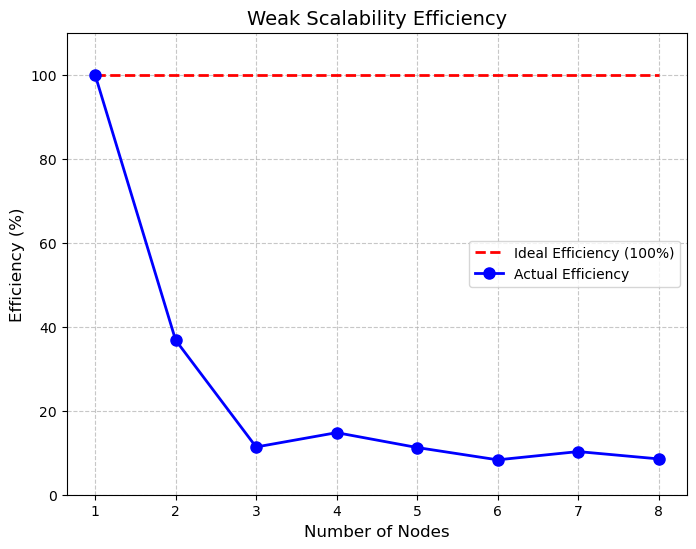

In [6]:
import matplotlib.pyplot as plt
nodes = [1, 2, 3, 4, 5, 6, 7, 8]

ideal_efficiency = [100] * len(nodes)
time = [89.79, 121.96, 263.39, 151.87, 159.82, 180.20, 124.88, 131.64]
actual_efficiency = [time[0]*100 / (p * time[i]) for i, p in enumerate(nodes)]

plt.figure(figsize=(8, 6))
plt.plot(nodes, ideal_efficiency, 'r--', label='Ideal Efficiency (100%)', linewidth=2)
plt.plot(nodes, actual_efficiency, 'bo-', label='Actual Efficiency', linewidth=2, markersize=8)

plt.xlabel("Number of Nodes", fontsize=12)
plt.ylabel("Efficiency (%)", fontsize=12)
plt.title("Weak Scalability Efficiency", fontsize=14)
plt.xticks(nodes)
plt.ylim(0, 110)  
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()
